## Import Library

In [ ]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [ ]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

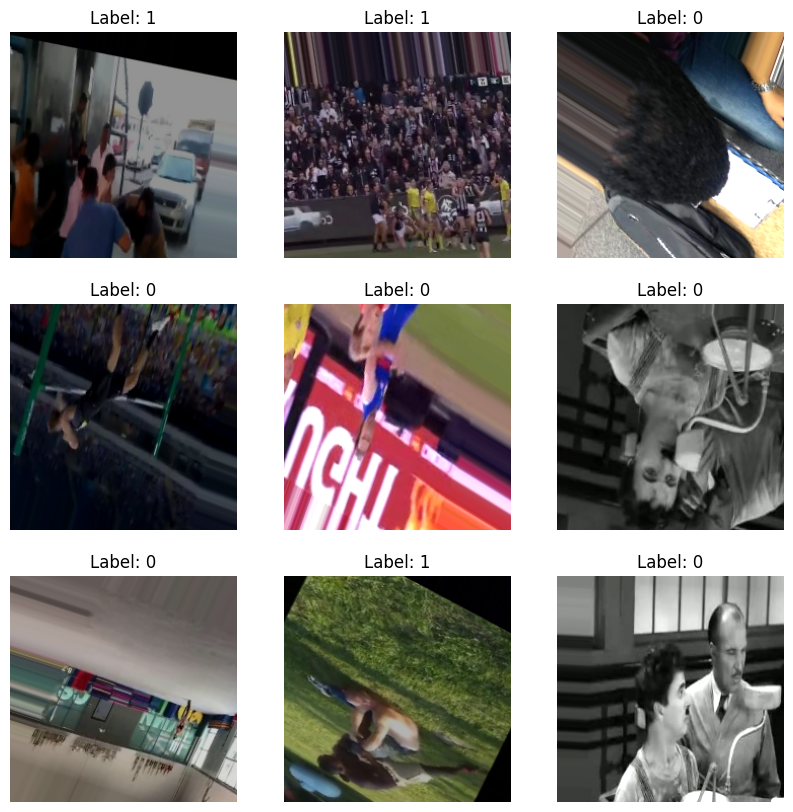

In [ ]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [ ]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_NoFreeze_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 15,110,465 (57.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.5041 - loss: 1.4205
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to NoMCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 802ms/step - accuracy: 0.5044 - loss: 1.4187 - val_accuracy: 0.5000 - val_loss: 11.4297
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.5356 - loss: 1.1389
Epoch 2: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 690ms/step - accuracy: 0.5358 - loss: 1.1382 - val_accuracy: 0.5000 - val_loss: 5.0021
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.5256 - loss: 1.0311
Epoch 3: val_accuracy improved from 0.50000 to 0.51364, saving model to NoMCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 720ms/step - accuracy: 0.5258 - loss: 1.0309 - val_accuracy: 0.5136 - val_loss: 4.6645
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.5759 - loss: 0.9430
Epoch 4: val_accuracy did not improve from 0.51364
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 698ms/step - accuracy: 0.5755 - loss: 0.9431 - val_accuracy: 0.5000 - val_loss: 62126.2734
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.5203 - loss: 0.9503
Epoch 5: val_accuracy did not improve from 0.51364
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 702ms/step - accuracy: 0.5206 - loss: 0.9503 - val_accuracy: 0.5000 - val_loss: 1.6651
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.5768 - loss: 0.8793
Epoch 6: val_accuracy did not improve from 0.51364
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 727ms/step - accuracy: 0.5770 - loss: 0.8789 - val_accuracy: 0.5045 - val_loss: 1.0576
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6215 - loss: 0.8341
Epoch 7: val_accuracy did n

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - accuracy: 0.5955 - loss: 0.7920 - val_accuracy: 0.6114 - val_loss: 0.7598
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5869 - loss: 0.7772
Epoch 10: val_accuracy improved from 0.61136 to 0.63409, saving model to NoMCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 728ms/step - accuracy: 0.5873 - loss: 0.7771 - val_accuracy: 0.6341 - val_loss: 0.7540
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.5654 - loss: 0.8008
Epoch 11: val_accuracy did not improve from 0.63409
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 713ms/step - accuracy: 0.5658 - loss: 0.8002 - val_accuracy: 0.5000 - val_loss: 6824.3110
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.6269 - loss: 0.7509
Epoch 12: val_accuracy improved from 0.63409 to 0.64545, saving model to NoMCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 714ms/step - accuracy: 0.6261 - loss: 0.7512 - val_accuracy: 0.6455 - val_loss: 0.7666
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.6338 - loss: 0.7407
Epoch 13: val_accuracy did not improve from 0.64545
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 697ms/step - accuracy: 0.6334 - loss: 0.7404 - val_accuracy: 0.5932 - val_loss: 0.7046
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6354 - loss: 0.7286
Epoch 14: val_accuracy improved from 0.64545 to 0.67500, saving model to NoMCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - accuracy: 0.6350 - loss: 0.7287 - val_accuracy: 0.6750 - val_loss: 0.6702
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.6221 - loss: 0.7021
Epoch 15: val_accuracy did not improve from 0.67500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 713ms/step - accuracy: 0.6219 - loss: 0.7024 - val_accuracy: 0.6409 - val_loss: 0.6694
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6152 - loss: 0.7047
Epoch 16: val_accuracy did not improve from 0.67500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 707ms/step - accuracy: 0.6152 - loss: 0.7047 - val_accuracy: 0.5000 - val_loss: 3.0401
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.6439 - loss: 0.6695
Epoch 17: val_accuracy did not improve from 0.67500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - accuracy: 0.6438 - loss: 0.6698 - val_accuracy: 0.5000 - val_loss: 1.4555
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6480 - loss: 0.6903
Epoch 18: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 717ms/step - accuracy: 0.7467 - loss: 0.5529 - val_accuracy: 0.7045 - val_loss: 0.5852
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.7506 - loss: 0.5596
Epoch 32: val_accuracy improved from 0.70455 to 0.76591, saving model to NoMCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - accuracy: 0.7503 - loss: 0.5596 - val_accuracy: 0.7659 - val_loss: 0.5343
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7483 - loss: 0.5456
Epoch 33: val_accuracy did not improve from 0.76591
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - accuracy: 0.7483 - loss: 0.5459 - val_accuracy: 0.5159 - val_loss: 1.8262
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7417 - loss: 0.5725
Epoch 34: val_accuracy did not improve from 0.76591
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.7423 - loss: 0.5719 - val_accuracy: 0.5000 - val_loss: 3.4751
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7631 - loss: 0.5175
Epoch 35: val_accuracy did not improve from 0.76591
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 707ms/step - accuracy: 0.7631 - loss: 0.5175 - val_accuracy: 0.5045 - val_loss: 1.4668
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.7775 - loss: 0.5279
Epoch 36: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - accuracy: 0.7887 - loss: 0.4893 - val_accuracy: 0.8091 - val_loss: 0.4509
Epoch 44/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7987 - loss: 0.4578
Epoch 44: val_accuracy did not improve from 0.80909
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - accuracy: 0.7986 - loss: 0.4581 - val_accuracy: 0.5523 - val_loss: 1.1129
Epoch 45/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7850 - loss: 0.4841
Epoch 45: val_accuracy did not improve from 0.80909
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 710ms/step - accuracy: 0.7852 - loss: 0.4838 - val_accuracy: 0.5114 - val_loss: 2.0385
Epoch 46/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8234 - loss: 0.4375
Epoch 46: val_accuracy did not improve from 0.80909
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 702ms/step - accuracy: 0.8231 - loss: 0.4378 - val_accuracy: 0.5864 - val_loss: 0.8416
Epoch 47/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8207 - loss: 0.4490
Epoch 47: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.2929 - loss: 1.5509
Validation Loss: 0.949582040309906
Validation Accuracy: 0.5636363625526428


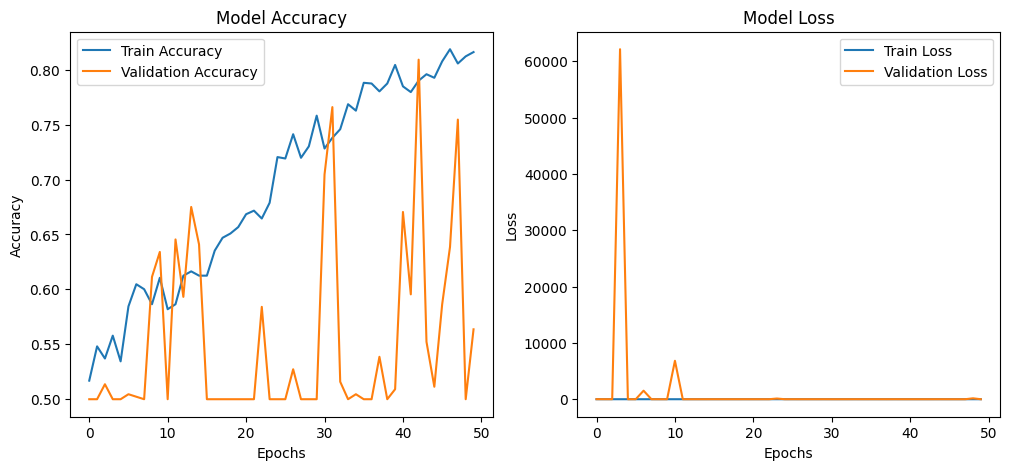

In [ ]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [ ]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_NoFreeze_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.6978 - loss: 0.5684
Test Accuracy : 77.03%
Test Loss     : 0.484


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step


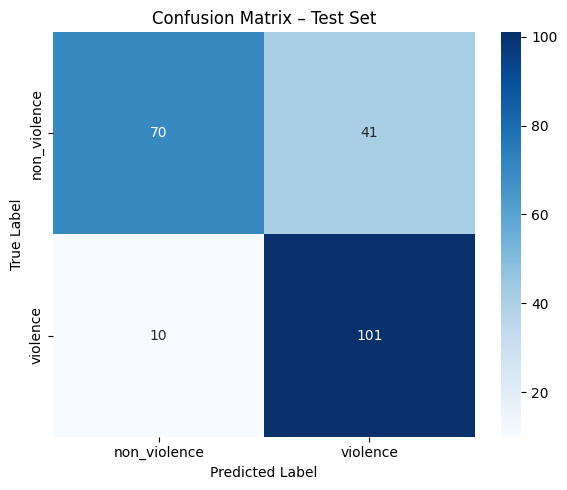


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.88      0.63      0.73       111
    violence       0.71      0.91      0.80       111

    accuracy                           0.77       222
   macro avg       0.79      0.77      0.77       222
weighted avg       0.79      0.77      0.77       222



In [ ]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))